In [1]:
import os
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from preprocessing import preprocess_text
from math import log10
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

In [2]:
train_dir = os.path.realpath("../assets/annotated_corpus/train")
result_dir = os.path.realpath("../assets/wordcount/train")

In [3]:
topics = os.listdir(train_dir)

# Task 1

In [4]:
def get_stems_processed(filepath):
    sentences = []
    pattern = r"([A-Za-z]+[-.@]?)+\w*\.?"
    with open(filepath) as f:
            lines = "".join(f.readlines())
            sentences_raw = lines.split("\n\n")
            for s in sentences_raw:
                stems = []
                words = s.split("\n")
                if len(words) == 0 or words[0] == "":
                    continue
                stems_raw = list(map(lambda x: x.split("\t")[2], words))
                lemmas = list(map(lambda x: x.split("\t")[2], words))
                for i in range(len(stems_raw)):
                    if lemmas[i] not in stopwords.words("english") and re.match(pattern, lemmas[i]) is not None:
                        stems.append(stems_raw[i])
                sentences.append(stems)
    return sentences

In [5]:
def count_words(sentences, count_by_sentences=False):
    word_count = {}
    sentences_count = []
    for words in sentences:
        s_count = {}
        for w in words:
            if w not in s_count.keys():
                s_count[w] = 0
            s_count[w] += 1
            if w not in word_count.keys():
                word_count[w] = 0
            word_count[w] += 1
        sentences_count.append(s_count)
    return sentences_count if count_by_sentences else word_count

In [6]:
all_documents = []
word_dict_raw = {}
for t in topics:
    workdir = os.path.join(train_dir, t)
    for filename in os.listdir(workdir):
        stems = get_stems_processed(os.path.join(workdir, filename))
        all_documents.append(stems)
        counts = count_words(stems)
        for w in counts.keys():
            if w not in word_dict_raw.keys():
                word_dict_raw[w] = 0
            word_dict_raw[w] += counts[w]
    break # process only 1st topic

In [7]:
word_dict = dict(word_dict_raw)

for w in word_dict_raw.keys():
    if word_dict_raw[w] < 90:
        del word_dict[w]

In [8]:
if not os.path.isdir(result_dir):
    os.makedirs(result_dir, exist_ok=True)
with open(os.path.join(result_dir, "dictionary.json"), "w") as f:
    json.dump(word_dict, f, indent=1)

In [9]:
doc_names = []
matrix_arr = []
for t in topics:
    workdir = os.path.join(train_dir, t)
    for filename in os.listdir(workdir):
        doc_names.append(t + "/" + filename)
        stems = get_stems_processed(os.path.join(workdir, filename))
        counts = count_words(stems)
        vec = []
        for w in word_dict.keys():
            if w in counts.keys():
                vec.append(counts[w])
            else:
                vec.append(0)
        matrix_arr.append(vec)
        if sum(vec) == 0:
            print("Zero vector for document", filename)
    break # process only 1st topic
    

In [10]:
matrix = pd.DataFrame(matrix_arr)
matrix.columns = word_dict.keys()
matrix.index = doc_names

In [11]:
matrix.head()

,atheist,religion,u,like,one,christian,word,people,get,go,...,want,another,nothing,tell,writes,muslim,objective,need,come,islamic
alt.atheism/49960.tsv,9,6,3,1,4,6,1,4,3,2,...,0,0,0,0,0,0,0,0,0,0
alt.atheism/51060.tsv,85,37,1,6,17,15,8,19,1,2,...,5,3,2,1,0,0,0,0,0,0
alt.atheism/51119.tsv,0,0,0,1,5,0,1,1,1,1,...,0,0,1,0,1,0,0,0,0,0
alt.atheism/51120.tsv,0,3,0,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
alt.atheism/51121.tsv,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [12]:
matrix.to_csv(os.path.join(result_dir, "term-document.csv"))

# Task 2

In [13]:
def tf_idf(words, matrix):
    total_words = sum(words.values())
    total_documents = len(matrix.index)
    result = []
    for w in matrix.columns:
        if w not in words:
            result.append(0.0)
            continue
        t_f = words[w] / total_words
        d_f = sum(matrix[w] > 0)
        tfidf = t_f * log10((total_documents + 1) / (d_f + 1))
        result.append(tfidf)
    return result

In [14]:
def vectorize_tf_idf(text, matrix):
    preprocessed = preprocess_text(text)
    text_dict = count_words([preprocessed])
    return tf_idf(text_dict, matrix)

In [15]:
matrix = pd.read_csv(os.path.join(result_dir, "term-document.csv"), index_col=0)

In [16]:
matrix.head()

,atheist,religion,u,like,one,christian,word,people,get,go,...,want,another,nothing,tell,writes,muslim,objective,need,come,islamic
alt.atheism/49960.tsv,9,6,3,1,4,6,1,4,3,2,...,0,0,0,0,0,0,0,0,0,0
alt.atheism/51060.tsv,85,37,1,6,17,15,8,19,1,2,...,5,3,2,1,0,0,0,0,0,0
alt.atheism/51119.tsv,0,0,0,1,5,0,1,1,1,1,...,0,0,1,0,1,0,0,0,0,0
alt.atheism/51120.tsv,0,3,0,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
alt.atheism/51121.tsv,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [17]:
t1 = """Evolution Designs sell the "Darwin fish".  It's a fish symbol, like the ones
Christians stick on their cars, but with feet and the word "Darwin" written
inside.  The deluxe moulded 3D plastic fish is $4.95 postpaid in the US."""

In [18]:
t2 = """A story based on the premise that the US Congress is mysteriously
assassinated, and fundamentalists quickly take charge of the nation to set it
"right" again.  The book is the diary of a woman's life as she tries to live
under the new Christian theocracy.  Women's right to own property is revoked,
and their bank accounts are closed; sinful luxuries are outlawed, and the
radio is only used for readings from the Bible.  Crimes are punished
retroactively: doctors who performed legal abortions in the "old world" are
hunted down and hanged.  Atwood's writing style is difficult to get used to
at first, but the tale grows more and more chilling as it goes on."""

In [19]:
vectorize_tf_idf(t1, matrix)

[0.0,
 0.0,
 0.0,
 0.0218768751774201,
 0.012432423012091104,
 0.03612550989803289,
 0.031028788166082465,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [20]:
vectorize_tf_idf(t2, matrix)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.015107031411904663,
 0.0,
 0.0,
 0.011437575143462036,
 0.0,
 0.01630573166114663,
 0.0,
 0.0,
 0.0,
 0.0,
 0.014674251145129666,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.012402637752251484,
 0.024648134639679607,
 0.0,
 0.0,
 0.015332654284301389,
 0.014674251145129666,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.013779378005671819,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

# Task 3

In [21]:
w2v = Word2Vec(sentences=[sentence for document in all_documents for sentence in document], epochs=40)

In [22]:
w2v.wv.most_similar("christian")

[('era', 0.6242043375968933),
 ('brown', 0.6150456666946411),
 ('became', 0.6050876975059509),
 ('honest', 0.5990947484970093),
 ('complain', 0.5651814937591553),
 ('coin', 0.5348435044288635),
 ('loving', 0.5299637317657471),
 ('miracle', 0.52959805727005),
 ('idea', 0.5284479856491089),
 ('arguing', 0.5245609879493713)]

# Task 4

In [23]:
def cosine_similarity(a, b):
    return np.dot(a, b)/(np.linalg.norm(a) * np.linalg.norm(b))

In [24]:
cosine_similarity(w2v.wv["christian"], w2v.wv["atheist"])

0.46441466

In [25]:
def draw_words(terms, vectors_source):
    pca = PCA(n_components=2)
    vectors_2d = pd.DataFrame(pca.fit_transform([vectors_source[term] for term in terms]))
    vectors_2d.index = terms
    vectors_2d.columns = ["x", "y"]
    
    p = sns.scatterplot(vectors_2d, x="x", y="y")
    for i in vectors_2d.index:
        item = vectors_2d.loc[i]
        p.text(item.x, item.y, i)
    return p

<Axes: xlabel='x', ylabel='y'>

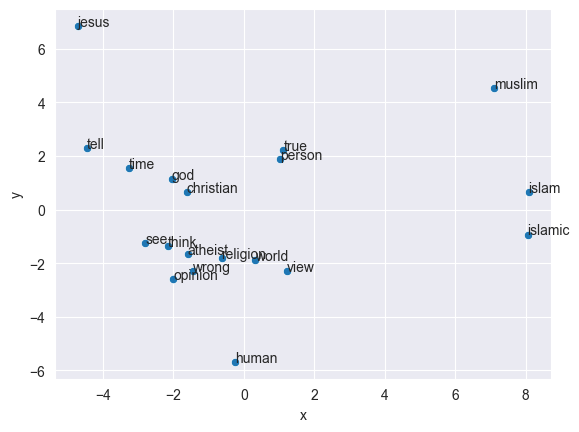

In [26]:
terms_to_check = ["christian", "jesus", "god", "muslim", "islamic", "islam", "atheist", "time", "world", "true", "wrong", "human", "person", "tell", "see", "opinion", "think", "view", "religion"]
draw_words(terms_to_check, w2v.wv)

# Task 5

In [28]:
def transform_to_compare(vectors):
    pca = PCA(n_components=len(w2v.wv[0]))
    transformed = pca.fit_transform(vectors)
    return transformed

In [29]:
terms_vectorized = [vectorize_tf_idf(i, matrix) for i in matrix.columns]

# Task 6

In [30]:
terms_to_compare = pd.DataFrame(transform_to_compare(terms_vectorized))
terms_to_compare.index = matrix.columns
terms_to_compare

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
atheist,-0.015747,-0.015390,-0.011894,-0.008664,-1.374645e-16,3.502237e-17,-0.013296,-0.008398,-9.670062e-17,-0.005530,...,1.595430e-18,6.119553e-19,-2.697863e-19,2.036501e-18,-6.307378e-19,-2.010128e-18,-3.348306e-19,-9.613560e-19,2.823311e-19,6.781970e-19
religion,-0.017133,-0.017173,-0.013512,-0.010480,-1.674401e-16,1.031841e-16,-0.017108,-0.011226,3.010585e-16,-0.008188,...,1.595430e-18,6.119553e-19,-2.697863e-19,2.036501e-18,-6.307378e-19,-2.010128e-18,-3.348306e-19,-9.613560e-19,2.823311e-19,6.781970e-19
u,-0.016449,-0.016282,-0.012696,-0.009536,-1.542849e-16,-5.119106e-16,-0.015068,-0.009686,-1.254883e-16,-0.006674,...,1.595430e-18,6.119553e-19,-2.697863e-19,2.036501e-18,-6.307378e-19,-2.010128e-18,-3.348306e-19,-9.613560e-19,2.823311e-19,6.781970e-19
like,-0.013604,-0.012804,-0.009647,-0.006479,4.415714e-17,-1.455129e-16,-0.009276,-0.005635,-3.143991e-16,-0.003389,...,1.595430e-18,6.119553e-19,-2.697863e-19,2.036501e-18,-6.307378e-19,-2.010128e-18,-3.348306e-19,-9.613560e-19,2.823311e-19,6.781970e-19
one,-0.012257,-0.011274,-0.008369,-0.005382,-1.464115e-16,-8.474203e-17,-0.007454,-0.004452,5.603275e-17,-0.002582,...,1.595430e-18,6.119553e-19,-2.697863e-19,2.036501e-18,-6.307378e-19,-2.010128e-18,-3.348306e-19,-9.613560e-19,2.823311e-19,6.781970e-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
muslim,-0.025079,-0.029440,-0.026460,-0.042638,-6.528967e-01,-4.670633e-01,0.548011,0.053057,1.593064e-15,0.011228,...,1.595430e-18,6.119553e-19,-2.697863e-19,2.036501e-18,-6.307378e-19,-2.010128e-18,-3.348306e-19,-9.613560e-19,2.823311e-19,6.781970e-19
objective,-0.011704,-0.010665,-0.007872,-0.004980,-8.066428e-17,7.717361e-18,-0.006816,-0.004047,-6.689624e-17,-0.002318,...,-1.672930e-17,1.761835e-17,3.936786e-18,9.699881e-18,-6.231424e-18,-7.656977e-18,-1.190479e-17,1.326562e-17,-3.571001e-17,1.774875e-17
need,-0.019649,-0.020649,-0.016841,-0.015073,-3.203775e-16,1.116208e-16,-0.029327,-0.021992,-4.356034e-16,-0.027178,...,1.595430e-18,6.119553e-19,-2.697863e-19,2.036501e-18,-6.307378e-19,-2.010128e-18,-3.348306e-19,-9.613560e-19,2.823311e-19,6.781970e-19
come,-0.017244,-0.017318,-0.013646,-0.010642,-4.543234e-16,1.706357e-16,-0.017471,-0.011507,-7.591945e-16,-0.008484,...,1.595430e-18,6.119553e-19,-2.697863e-19,2.036501e-18,-6.307378e-19,-2.010128e-18,-3.348306e-19,-9.613560e-19,2.823311e-19,6.781970e-19


In [31]:
def compare_methods(w1, w2):
    print("Results for words", w1, "and", w2)
    print("W2V:", cosine_similarity(w2v.wv[w1], w2v.wv[w2]))
    print("Tf-Idf:", cosine_similarity(terms_to_compare.loc[w1], terms_to_compare.loc[w2]))
    print()

In [32]:
compare_methods("islam", "islamic")
compare_methods("say", "tell")
compare_methods("say", "islam")

Results for words islam and islamic
W2V: 0.55658764
Tf-Idf: 1.0000000000000002

Results for words say and tell
W2V: 0.33421552
Tf-Idf: -0.01419358812209615

Results for words say and islam
W2V: 0.066667095
Tf-Idf: -0.040002382194207084


In [33]:
cosine_similarity([-1, -2, -4], [1, 2, 4])

-1.0

In [34]:
tfidf_data = {}
for i in range(len(matrix.columns)):
    tfidf_data[matrix.columns[i]] = terms_vectorized[i]

<Axes: xlabel='x', ylabel='y'>

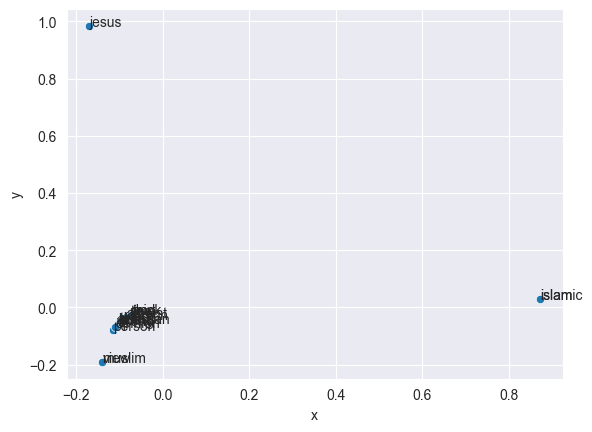

In [35]:
draw_words(terms_to_check, tfidf_data)

# Task 7

In [72]:
def vectorize(sentences, w2v):
    result_vec = np.zeros(w2v.vector_size)
    for s in sentences:
        sentence_vec = np.zeros(w2v.vector_size)
        for w in s:
            if w2v.wv.has_index_for(w):
                sentence_vec += w2v.wv[w]
        sentence_vec = sentence_vec / len(s) if len(s) > 0 else np.zeros(w2v.vector_size)
        result_vec += sentence_vec
    result_vec = result_vec / len(sentences) if len(sentences) > 0 else np.zeros(w2v.vector_size)
    return result_vec

In [73]:
preprocess_text(t1, True)

[['evolut', 'design', 'sell', 'darwin', 'fish'],
 ['fish', 'symbol', 'like', 'one'],
 ['christian', 'stick', 'car', 'feet', 'word', 'darwin', 'written'],
 ['delux', 'mould', '3d', 'plastic', 'fish', 'postpaid', 'us']]

In [74]:
vectorize(preprocess_text(t1, True), w2v)

array([-0.04204241,  0.03296237,  0.08700531,  0.0746068 , -0.07086271,
       -0.26138871, -0.0418698 ,  0.37853981, -0.08717171, -0.08237496,
       -0.06488097, -0.1278687 , -0.08095836,  0.00680424, -0.08224174,
        0.01699184, -0.04895443, -0.17025995,  0.12479181, -0.29970902,
        0.21093774,  0.03805543, -0.01077029, -0.25536796, -0.01965586,
        0.00135228, -0.10755542, -0.05358405, -0.13557458,  0.09985812,
        0.02510427, -0.06889696, -0.06129372, -0.15732238, -0.01856953,
        0.04396223, -0.04401058, -0.11649604,  0.06344152, -0.09122724,
        0.01105387, -0.09118546, -0.114892  , -0.06795187,  0.23766756,
       -0.04335369,  0.04365114, -0.10674193,  0.0201255 ,  0.10615522,
        0.04812667,  0.02016139,  0.10588337,  0.05173719, -0.06125754,
       -0.06986161,  0.03673267,  0.0705549 , -0.05413383, -0.00873108,
        0.00530004, -0.03378986,  0.06994757,  0.12380662, -0.24027117,
        0.15178992, -0.03573252,  0.06029197, -0.06825111,  0.12

 # Task 8

In [75]:
vectorized_documents = {}
for t in topics:
    workdir = os.path.join(train_dir, t)
    for filename in os.listdir(workdir):
        stems = get_stems_processed(os.path.join(workdir, filename))
        vectorized_documents[os.path.join(t, filename)] = vectorize(stems, w2v)
    break # process only 1st topic

In [76]:
with open(os.path.join(train_dir, "..", "train_embeddings.tsv"), "w") as f:
    for k in vectorized_documents.keys():
        print(k.replace(".tsv", ""), *vectorized_documents[k], sep="\t", file=f)